# Image Augmentation for Normal Images and Anomalies of L4V Anomaly Localization Dataset


### 1 Normal image augmentation
we use imgaug library to perform various image augmentation techniques to a single image to generate a normal image dataset including adjusting the image contrast by scaling pixel values such as GammaContrast, SigmoidContrast,LinearContrast and adding Gaussian noises to the image.

In [ ]:
!pip install imgaug

In [ ]:
!pip install ipyplot

In [3]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import ipyplot
from PIL import Image
import os
import shutil

In [4]:
import boto3
s3=boto3.client('s3')

#### make the image directory

In [5]:
# make the image directory
dir_im="images"
if not os.path.isdir(dir_im):
    os.makedirs(dir_im)

#### Generate 10 images for each of the following transformations: GammaContrast, SigmoidContrast,LinearContrast and adding Gaussian noises to the image and save them in the image directory we just created

In [6]:
# create augmented images from original image
input_img = imageio.imread('s10.png')
input_contrast_list=[]
sigmoid_contrast_list=[]
linear_contrast_list=[]
input_noise_list=[]

for i in range(10):
    noise=iaa.AdditiveGaussianNoise(scale=0.2*255)
    contrast=iaa.GammaContrast((0.5,2))
    contrast_sig = iaa.SigmoidContrast(gain=(5,20), cutoff=(0.25, 0.75))
    contrast_lin = iaa.LinearContrast((0.4,1.6))
       
    input_noise=noise.augment_image(input_img)
    input_contrast = contrast.augment_image(input_img)
    sigmoid_contrast = contrast_sig.augment_image(input_img)
    linear_contrast = contrast_lin.augment_image(input_img)
      
    im_noise = Image.fromarray(input_noise)
    im_noise.save(f'{dir_im}/input_noise_{i}.png')

    im_input_contrast = Image.fromarray(input_contrast)
    im_input_contrast.save(f'{dir_im}/contrast_sig_{i}.png')

    im_sigmoid_contrast = Image.fromarray(sigmoid_contrast)
    im_sigmoid_contrast.save(f'{dir_im}/sigmoid_contrast_{i}.png')

    im_linear_contrast = Image.fromarray(linear_contrast)
    im_linear_contrast.save(f'{dir_im}/linear_contrast_{i}.png')
    
    input_noise_list.append(input_noise)
    input_contrast_list.append(input_contrast)
    sigmoid_contrast_list.append(sigmoid_contrast)
    linear_contrast_list.append(linear_contrast)

#### move the original image to the image directory as well

In [7]:
shutil.move('s10.png','images/s10.png')

'images/s10.png'

In [8]:
imlist =  [file for file in os.listdir(dir_im) if file.endswith('.png')]
imlist

['s10.png',
 'linear_contrast_9.png',
 'input_noise_7.png',
 'sigmoid_contrast_2.png',
 'sigmoid_contrast_8.png',
 'linear_contrast_0.png',
 'linear_contrast_4.png',
 'input_noise_8.png',
 'linear_contrast_7.png',
 'input_noise_6.png',
 'sigmoid_contrast_7.png',
 'input_noise_0.png',
 'input_noise_4.png',
 'input_noise_1.png',
 'sigmoid_contrast_4.png',
 'contrast_sig_8.png',
 'linear_contrast_1.png',
 'contrast_sig_4.png',
 'linear_contrast_8.png',
 'sigmoid_contrast_9.png',
 'linear_contrast_2.png',
 'sigmoid_contrast_0.png',
 'sigmoid_contrast_1.png',
 'sigmoid_contrast_3.png',
 'sigmoid_contrast_5.png',
 'linear_contrast_6.png',
 'contrast_sig_6.png',
 'input_noise_2.png',
 'input_noise_5.png',
 'contrast_sig_3.png',
 'contrast_sig_0.png',
 'sigmoid_contrast_6.png',
 'contrast_sig_9.png',
 'linear_contrast_3.png',
 'input_noise_3.png',
 'linear_contrast_5.png',
 'contrast_sig_2.png',
 'input_noise_9.png',
 'contrast_sig_5.png',
 'contrast_sig_7.png',
 'contrast_sig_1.png']

#### Upload all the agumented images including the original image to a target s3 bucket

In [9]:
# upload augmented images to s3 bucket
s3_bucket='qualityinspection'
for i in range(len(imlist)):
    with open('images/'+imlist[i], 'rb') as data:
        s3.upload_fileobj(data, s3_bucket, 'images/'+imlist[i])

In [10]:
# get the image s3 locations
im_s3_list=[]
for i in range(len(imlist)):
    image_s3='s3://qualityinspection/images/'+imlist[i]
    im_s3_list.append(image_s3)

### 2 Prepare Endpoint Input

In [14]:
# download Ground Truth annotation mask image to local
#s3.download_file('pcbtest22', 'label/S10-label3/annotations/consolidated-annotation/output/0_2022-09-09T17:25:31.918770.png', 'mask.png')

In [17]:
#download output manifest to local 
#s3.download_file('pcbtest22', 'label/S10-label3/manifests/output/output.manifest', 'output.manifest')

In [16]:
# upload mask to mask folder 
s3.upload_file('mask.png', 'qualityinspection', 'mask/mask.png')

In [11]:
import json
with open('output.manifest','rt') as the_new_file:
    lines=the_new_file.readlines()
    for line in lines:
        json_line = json.loads(line)

In [12]:
# create input dictionary
input_dat=dict()
input_dat['input-image-location']=im_s3_list
input_dat['mask-location']='s3://qualityinspection/mask/mask.png'
input_dat['mask-info']=json_line['S10-label3-ref-metadata']['internal-color-map']
input_dat['output-bucket']='qualityinspection'
input_dat['output-project']='synthetic_defect'

In [13]:
# Write the input intext file and upload to s3 location
input_name='input.txt'
with open(input_name, 'w') as the_new_file:
    the_new_file.write(json.dumps(input_dat))

#### upload the input file to input folder in the target s3 bucket

In [14]:
s3.upload_file('input.txt', 'qualityinspection', 'input/input.txt')

### 3 Visualization of 40 Augmented Normal Images 

In [15]:
images_list=[input_img]+input_contrast_list+sigmoid_contrast_list+linear_contrast_list+input_noise_list

Text(0.5, 1.0, 'Gaussian Noise Image 10')

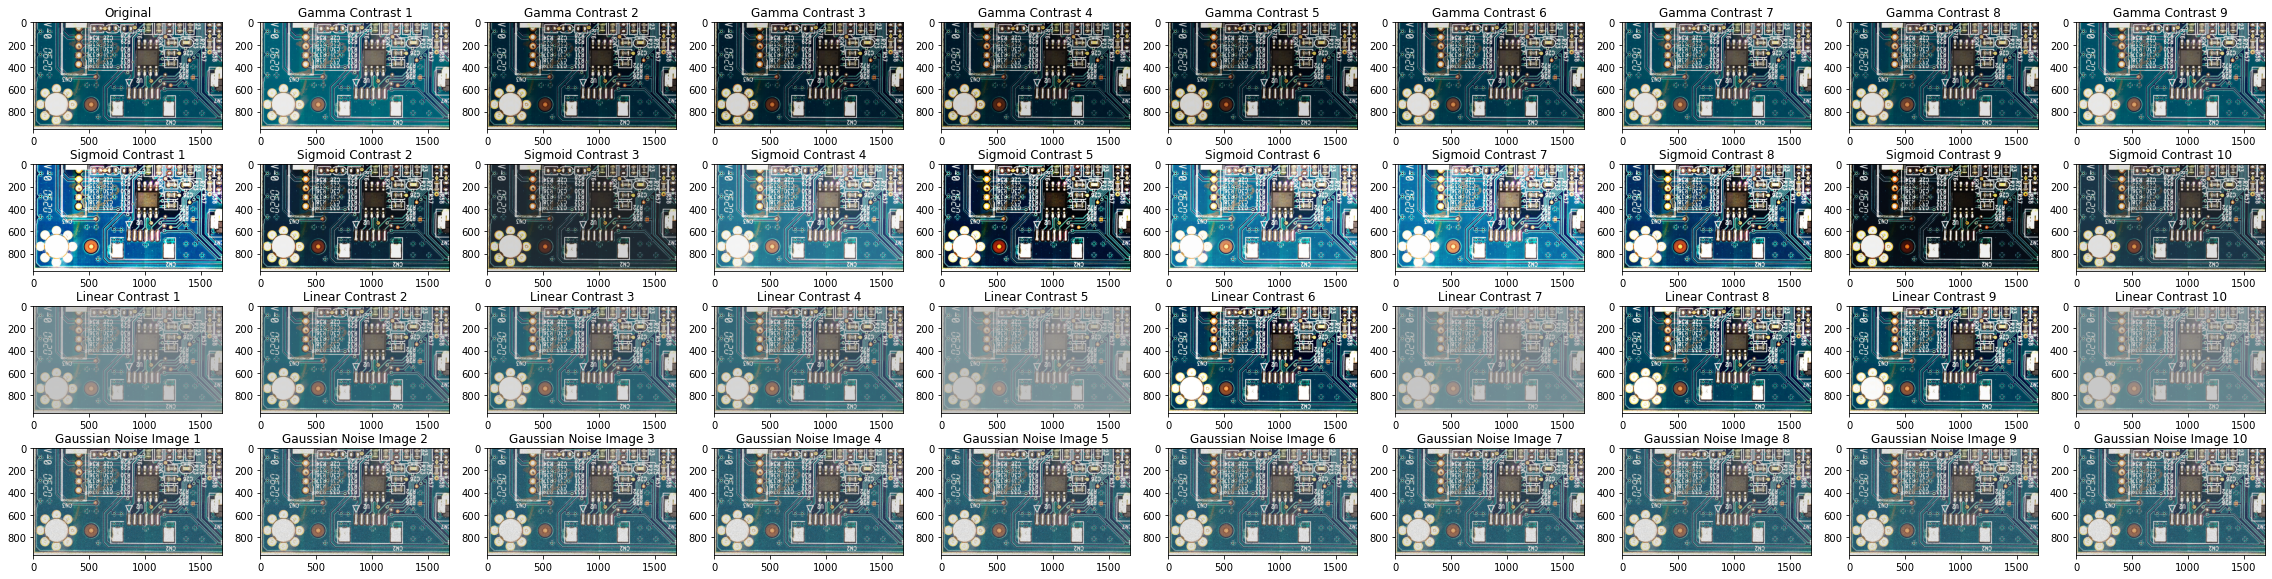

In [16]:
from matplotlib import pyplot as plt
f,axs=plt.subplots(4,10,figsize=(40,10)) #ROW,COLUMN

axs[0,0].imshow(images_list[0])
axs[0,0].set_title('Original')
axs[0,1].imshow(images_list[2])
axs[0,1].set_title('Gamma Contrast 1')
axs[0,2].imshow(images_list[3])
axs[0,2].set_title('Gamma Contrast 2')
axs[0,3].imshow(images_list[4])
axs[0,3].set_title('Gamma Contrast 3')
axs[0,4].imshow(images_list[5])
axs[0,4].set_title('Gamma Contrast 4')
axs[0,5].imshow(images_list[6])
axs[0,5].set_title('Gamma Contrast 5')
axs[0,6].imshow(images_list[7])
axs[0,6].set_title('Gamma Contrast 6')
axs[0,7].imshow(images_list[8])
axs[0,7].set_title('Gamma Contrast 7')
axs[0,8].imshow(images_list[9])
axs[0,8].set_title('Gamma Contrast 8')
axs[0,9].imshow(images_list[10])
axs[0,9].set_title('Gamma Contrast 9')

axs[1,0].imshow(images_list[11])
axs[1,0].set_title('Sigmoid Contrast 1')
axs[1,1].imshow(images_list[12])
axs[1,1].set_title('Sigmoid Contrast 2')
axs[1,2].imshow(images_list[13])
axs[1,2].set_title('Sigmoid Contrast 3')
axs[1,3].imshow(images_list[14])
axs[1,3].set_title('Sigmoid Contrast 4')
axs[1,4].imshow(images_list[15])
axs[1,4].set_title('Sigmoid Contrast 5')
axs[1,5].imshow(images_list[16])
axs[1,5].set_title('Sigmoid Contrast 6')
axs[1,6].imshow(images_list[17])
axs[1,6].set_title('Sigmoid Contrast 7')
axs[1,7].imshow(images_list[18])
axs[1,7].set_title('Sigmoid Contrast 8')
axs[1,8].imshow(images_list[19])
axs[1,8].set_title('Sigmoid Contrast 9')
axs[1,9].imshow(images_list[20])
axs[1,9].set_title('Sigmoid Contrast 10')

axs[2,0].imshow(images_list[21])
axs[2,0].set_title('Linear Contrast 1')
axs[2,1].imshow(images_list[22])
axs[2,1].set_title('Linear Contrast 2')
axs[2,2].imshow(images_list[23])
axs[2,2].set_title('Linear Contrast 3')
axs[2,3].imshow(images_list[24])
axs[2,3].set_title('Linear Contrast 4')
axs[2,4].imshow(images_list[25])
axs[2,4].set_title('Linear Contrast 5')
axs[2,5].imshow(images_list[26])
axs[2,5].set_title('Linear Contrast 6')
axs[2,6].imshow(images_list[27])
axs[2,6].set_title('Linear Contrast 7')
axs[2,7].imshow(images_list[28])
axs[2,7].set_title('Linear Contrast 8')
axs[2,8].imshow(images_list[29])
axs[2,8].set_title('Linear Contrast 9')
axs[2,9].imshow(images_list[30])
axs[2,9].set_title('Linear Contrast 10')
                   

                   
axs[3,0].imshow(images_list[31])
axs[3,0].set_title('Gaussian Noise Image 1')
axs[3,1].imshow(images_list[32])
axs[3,1].set_title('Gaussian Noise Image 2')
axs[3,2].imshow(images_list[33])
axs[3,2].set_title('Gaussian Noise Image 3')
axs[3,3].imshow(images_list[34])
axs[3,3].set_title('Gaussian Noise Image 4')
axs[3,4].imshow(images_list[35])
axs[3,4].set_title('Gaussian Noise Image 5')
axs[3,5].imshow(images_list[36])
axs[3,5].set_title('Gaussian Noise Image 6')
axs[3,6].imshow(images_list[37])
axs[3,6].set_title('Gaussian Noise Image 7')
axs[3,7].imshow(images_list[38])
axs[3,7].set_title('Gaussian Noise Image 8')
axs[3,8].imshow(images_list[39])
axs[3,8].set_title('Gaussian Noise Image 9')
axs[3,9].imshow(images_list[40])
axs[3,9].set_title('Gaussian Noise Image 10')